# ResNet from scratch
In this notebook I will build a **ResNet-50** from scratch with MixUp and test it on a subset of Imagenet. 

*Based on [fastai lesson 14](https://github.com/fastai/fastbook/blob/master/14_resnet.ipynb).*

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

# Data
-------


I will use **Imagenette**, which is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

Specifically, I will use **Imagenette_320** which have their shortest side resized to 320px, with their aspect ratio maintained.

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [4]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

File downloaded is broken. Remove /root/.fastai/archive/imagenette2-320.tgz and try again.


In [21]:
train_samples, valid_samples = len(dls.train_ds), len(dls.valid_ds)
percent_valid = valid_samples / (train_samples + valid_samples) * 100
print("Train samples: {}, Validation samples: {}\n% of validation over total dataset: {:.2f}%".format(train_samples, valid_samples, percent_valid))

Train samples: 9469, Validation samples: 3925
% of validation over total dataset: 29.30%


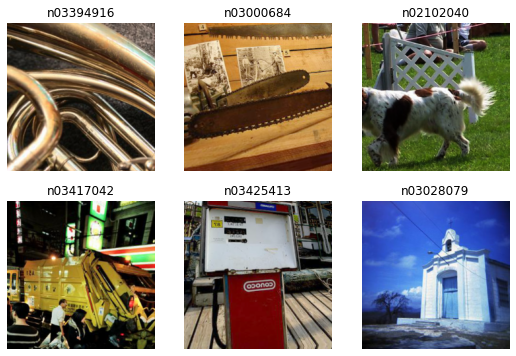

In [5]:
dls.show_batch(max_n=6)

### Stem
First, I define the stem (some convolutional layers followed by a maxpooling layer), which is the first part of the model. I will use it as the beginning of the ResNet because it is where most of the computation occurs. It is better to keep things simple and fast in the early layers.

In [30]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

### Bottleneck layer
I use **Bottleneck layers** in order to be able to use more channels without increasing computation. 

The last layer of the block has *norm_type=NormType.BatchZero*, this means that the **gamma weights of the last batchnorm layer are initialized to zero**. Because of this the the block will start by being equal to zero, so the neural net will only transform the parameters of this layers if they improve the loss. If not they will not do anything.

In [31]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

### ResNet blocks
This will use the blocks above (bottleneck layers).
If the block above is called **f()**, the ResBlock will perform **x + f(x)**.

In addition, it has a convolutional layer of stride one and an average pooling layer. Those two are used in case that **x** (the input that is passed to the end of the ResBlock) and **f(x)** (the result of the _conv_block) differ on grid size or channels.

In [32]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

### ResNet
Now I combine all the pieces. Depending on the number of ResBlocks in each group I will get a different architecture.

For ResNet-18: layers = [2,2,2,2]

For Resnet-50: layers = [3,4,6,3]

In [33]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

## Trainning 
----

### ResNet-50 + MixUp + Half precicion digits (fp16) 
I add MixUp to avoid overfitting and improve generalization.

I convert the model to half precision digits to add some randomization and speed up the trainning.

In [34]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [27]:
learn = Learner(dls, rn, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp()).to_fp16()

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.7585775852203369)

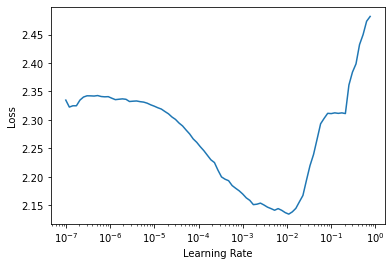

In [28]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.882966,1.575945,0.491720,01:07
1,1.702364,1.400535,0.550828,01:08
2,1.578514,1.294170,0.597707,01:08
3,1.520229,1.310346,0.580127,01:07
4,1.475888,1.368669,0.556943,01:07
5,1.443259,2.206281,0.406115,01:08
6,1.409453,1.337985,0.560000,01:08
7,1.387029,1.478290,0.586242,01:07
8,1.343409,1.232491,0.598471,01:07
9,1.313021,1.725219,0.562548,01:07


### Some predictions

In [ ]:
cats = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

In [ ]:
def predict_from_validation(i):
  print("Prediction: {}, True label: {}".format(cats[np.argmax(learn.predict(dls.valid_ds[i][0])[1])], cats[dls.valid_ds[i][1]]))
  return dls.valid_ds[i][0]

Prediction: garbage truck, True label: garbage truck


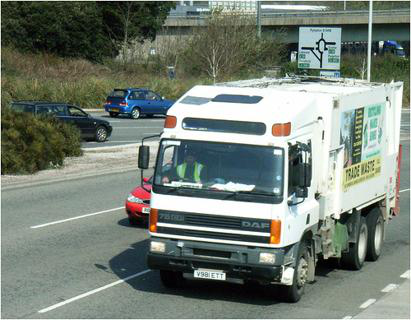

In [ ]:
predict_from_validation(555)

Prediction: church, True label: church


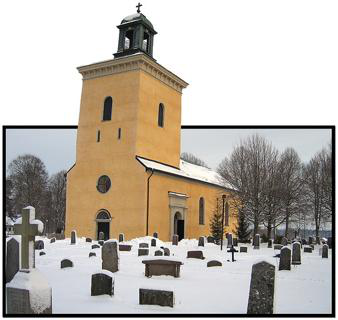

In [ ]:
predict_from_validation(111)

Prediction: French horn, True label: French horn


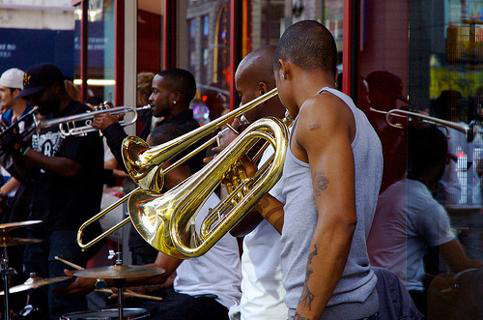

In [ ]:
predict_from_validation(899)